# Time series generation with Non-Linear ARMA process

## Non-Linear ARMA data generator with 6 features and concept drift in binary labeling function

Tthere are 6 features, each of them cross-correlated with other 2 features.
As a result, $x_1$, $x_2$, $x_3$ are cross-correlated, and $x_4$, $x_5$, $x_6$ are cross-correlated. Moreover, these variable are not all cross-correlated between all of them
The features are composed by a polynomial comnination of order 2 of the features and the noise.
The process is a non linear $ARMA(p, q)$, where $(p, q) = (5, 8)$ for the creation of this dataset.
The dataset is composed of 20000 time steps

In [82]:
import numpy as np
import matplotlib.pyplot as plt

time_series_length = 20000
features = 6

# initialization of X and eps (gaussian noise)
X = np.zeros((features, time_series_length))
eps = np.random.normal(0, 0.1, (features, time_series_length))

p = 5
q = 8

# first p values of X1 taken from normal distribution
#X[:, 0:q] = np.random.normal(0, 5, (features, q))

print(f"creation of X time series representing a NARMA({p},{q}) process of length {time_series_length}...")

# x1, eps1, x1^2, eps1^2, x1*eps1, x2, x2^2, x1*x2, x3, x3^2, x1*x3
# x4, eps4, x4^2, eps4^2, x4*eps4, x5, x5^2, x4*x5, x6, x6^2, x4*x6
# 5 auto correlation paramteres (x1 and eps1) + 2 cross correlations with other 2 features
parameters = p + q + p + q + p*q + (p + p + p*p) * 2
print("number of parameters: ", parameters)

creation of X time series representing a NARMA(5,8) process of length 20000...
number of parameters:  136


Creation of the non linear arma process generating function. Each feature is computed separately, in order to manually insert the cross-correlation between the variables.

An ARMA process follows this general formula:
$$ x(t) = \sum _{i=1}^{p} \phi_i x(t-i) + \sum_{i=1}^{q} \theta _i \varepsilon (t-i) + \varepsilon (t) $$

where the noise is gaussian distributed and indipendently and identically distributed:
$$ \varepsilon \sim Normal (0, 0.5^2)$$

The non linear ARMA process used in this notebook is a quadratic combination of both the gaussian noise and the process model. So we can express this dependence as: 
$$ x(t) = \left[ \sum _{i=1}^{p} \phi_i x(t-i) + \sum_{i=1}^{q} \theta _i \varepsilon (t-i) \right] ^2 + \varepsilon (t) $$

Therefore, the dependence of $x(t)$ on past values and the error terms $ \varepsilon(t)$ is non linear, that's why it is called a NARMA process.



In this particular setting, there are 6 features, representing 6 different processes, cross-correlated between each other, so the formula is more complicated, as it takes into account many more parameters. The following formulas represent the computation employed to compute the dot product between the random coefficients and the parameters for the non linear combination of the features processes and the gaussian noise

$$

\begin{aligned}
\forall \; i \in [1, p] \quad \forall \; j \in [1, q] \\

\text{polynomial[0]} &= \left[ \begin{matrix}
X_{0}(t-i) & \varepsilon_{0}(t-j) & X_{0}^{2}(t-i) & \varepsilon_{0}^{2}(t-j) & X_{0}(t-i)\varepsilon_{0}(t-j) \end{matrix}\right. \\
&\qquad \left.\begin{matrix}
& X_{1}(t-i) & X_{1}^{2}(t-i) & X_{0}(t-i)X_{1}(t-i) & X_{2}(t-i) & X_{2}^{2}(t-i) & X_{0}(t-i)X_{2}(t-i)
 \end{matrix} \right] ^T \\


\text{coefficients} &\sim {N} \left( 
	\begin{bmatrix}0 \\ \vdots \\ 0 \end{bmatrix},
	\begin{bmatrix}
	0.04 & 0 & \cdots & 0 \\
	0 & 0.04 & \cdots & 0 \\
	\vdots & \vdots & \ddots & \vdots \\
	0 & 0 & \cdots & 0.04
	\end{bmatrix} ^ 2
	 \right) \\

\forall \; f \in [0, \text{features}] &: \\
\quad x_{f}(t) &=  \text{coefficients}[f] \cdot \text{polynomial}[f] + \varepsilon_{f}(t)
\end{aligned}

$$

The covariance matrix of the coefficients has very small values ($0.04^2$) because of the instability of the NARMA process. In fact, putting higher values than these, with the above values of $p, q$ and a very long time series with $20000$ time steps, will cause an instable process, that becomes divergent after few time steps. So, by maintaining the covariance matrix small in terms of values, prevents instable processes.

Furthermore, the code above shows only the first process as an example. The other processes are computed in a similar manner, with different correlations between the features.

The coefficients for every paramter are picked by a random normal distribution, as well as the gaussian noise values.


In [83]:
def compute_polynomials(X, t):
	polynomial = np.zeros((features, parameters), dtype=np.float32)
	
	# polynomial combination of order 2 of X0 and eps0, and X[0:4]
	vector = np.array(np.concatenate([
						[X[0][t-i] for i in range(1, p+1)], [eps[0][t-i] for i in range(1, q+1)], 
						[X[0][t-i] **2 for i in range(1, p+1)], [eps[0][t-i] **2 for i in range(1, q+1)],
						[X[0][t-i] * eps[0][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[1][t-i] for i in range(1, p+1)], [X[1][t-i] **2 for i in range(1, p+1)],
						[X[1][t-i] * X[0][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[2][t-i] for i in range(1, p+1)], [X[2][t-i] **2 for i in range(1, p+1)],
						[X[2][t-i] * X[0][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# create array with 5 rows, and vector as the content of the first row
	polynomial[0] = np.array([vector])

	# polynomial combination of order 2 of X1 and eps1, and X[0:4]
	vector = np.array(np.concatenate([
						[X[1][t-i] for i in range(1, p+1)], [eps[1][t-i] for i in range(1, q+1)], 
						[X[1][t-i] **2 for i in range(1, p+1)], [eps[1][t-i] **2 for i in range(1, q+1)],
						[X[1][t-i] * eps[1][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[0][t-i] for i in range(1, p+1)], [X[0][t-i] **2 for i in range(1, p+1)],
						[X[0][t-i] * X[1][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[2][t-i] for i in range(1, p+1)], [X[2][t-i] **2 for i in range(1, p+1)],
						[X[2][t-i] * X[1][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# add vector to polynomial
	#polynomial = np.append(polynomial, [vector], axis=0)
	polynomial[1] = np.array([vector])


	# polynomial combination of order 2 of X2 and eps2, and X[0:4]
	vector = np.array(np.concatenate([
						[X[2][t-i] for i in range(1, p+1)], [eps[2][t-i] for i in range(1, q+1)], 
						[X[2][t-i] **2 for i in range(1, p+1)], [eps[2][t-i] **2 for i in range(1, q+1)],
						[X[2][t-i] * eps[2][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[0][t-i] for i in range(1, p+1)], [X[0][t-i] **2 for i in range(1, p+1)],
						[X[0][t-i] * X[2][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[1][t-i] for i in range(1, p+1)], [X[1][t-i] **2 for i in range(1, p+1)],
						[X[1][t-i] * X[2][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# add vector to polynomial
	#polynomial = np.append(polynomial, [vector], axis=0)
	polynomial[2] = np.array([vector])


	# polynomial combination of order 2 of X3 and eps3, and X4 and X5
	vector = np.array(np.concatenate([
						[X[3][t-i] for i in range(1, p+1)], [eps[3][t-i] for i in range(1, q+1)], 
						[X[3][t-i] **2 for i in range(1, p+1)], [eps[3][t-i] **2 for i in range(1, q+1)],
						[X[3][t-i] * eps[3][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[4][t-i] for i in range(1, p+1)], [X[4][t-i] **2 for i in range(1, p+1)],
						[X[4][t-i] * X[3][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[5][t-i] for i in range(1, p+1)], [X[5][t-i] **2 for i in range(1, p+1)],
						[X[5][t-i] * X[3][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# add vector to polynomial
	#polynomial = np.append(polynomial, [vector], axis=0)
	polynomial[3] = np.array([vector])


	# polynomial combination of order 2 of X4 and eps4, and X3, X5
	vector = np.array(np.concatenate([
						[X[4][t-i] for i in range(1, p+1)], [eps[4][t-i] for i in range(1, q+1)], 
						[X[4][t-i] **2 for i in range(1, p+1)], [eps[4][t-i] **2 for i in range(1, q+1)],
						[X[4][t-i] * eps[4][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[3][t-i] for i in range(1, p+1)], [X[3][t-i] **2 for i in range(1, p+1)],
						[X[3][t-i] * X[4][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[5][t-i] for i in range(1, p+1)], [X[5][t-i] **2 for i in range(1, p+1)],
						[X[5][t-i] * X[4][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# add vector to polynomial
	#polynomial = np.append(polynomial, [vector], axis=0)
	polynomial[4] = np.array([vector])

	# polynomial combination of order 2 of X4 and eps4, and X3, X5
	vector = np.array(np.concatenate([
						[X[5][t-i] for i in range(1, p+1)], [eps[5][t-i] for i in range(1, q+1)], 
						[X[5][t-i] **2 for i in range(1, p+1)], [eps[5][t-i] **2 for i in range(1, q+1)],
						[X[5][t-i] * eps[5][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[3][t-i] for i in range(1, p+1)], [X[3][t-i] **2 for i in range(1, p+1)],
						[X[3][t-i] * X[5][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[4][t-i] for i in range(1, p+1)], [X[4][t-i] **2 for i in range(1, p+1)],
						[X[4][t-i] * X[5][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# add vector to polynomial
	#polynomial = np.append(polynomial, [vector], axis=0)
	polynomial[5] = np.array([vector])

	return polynomial
	

Computation of a linear combination (via dot product) between the coefficients and the polynomial parameters of the NARMA processes. The computation is carried out at each time stamp, and for every feature. The dataset is then created 

In [84]:

# array of coefficients taken from normal distribution with mean 0 and variance 0.05 of shape = vector.shape
coefficients = np.random.normal(0, 0.1, (features, parameters))
print("coefficient shape = ", coefficients.shape)

# for each time stamp t in the time series
for t in range(max(p, q), time_series_length):
    # compute polynomial combination of order 2 for all features and time steps
    polynomial = compute_polynomials(X, t)
    
    for f in range(features):
        # compute dot product between coefficients and polynomial, for every f
        X[f][t] = np.dot(coefficients[f], polynomial[f]) + eps[f][t]

print("dataset shape = ", X.shape)


coefficient shape =  (6, 136)
dataset shape =  (6, 20000)


Plot the 6 features

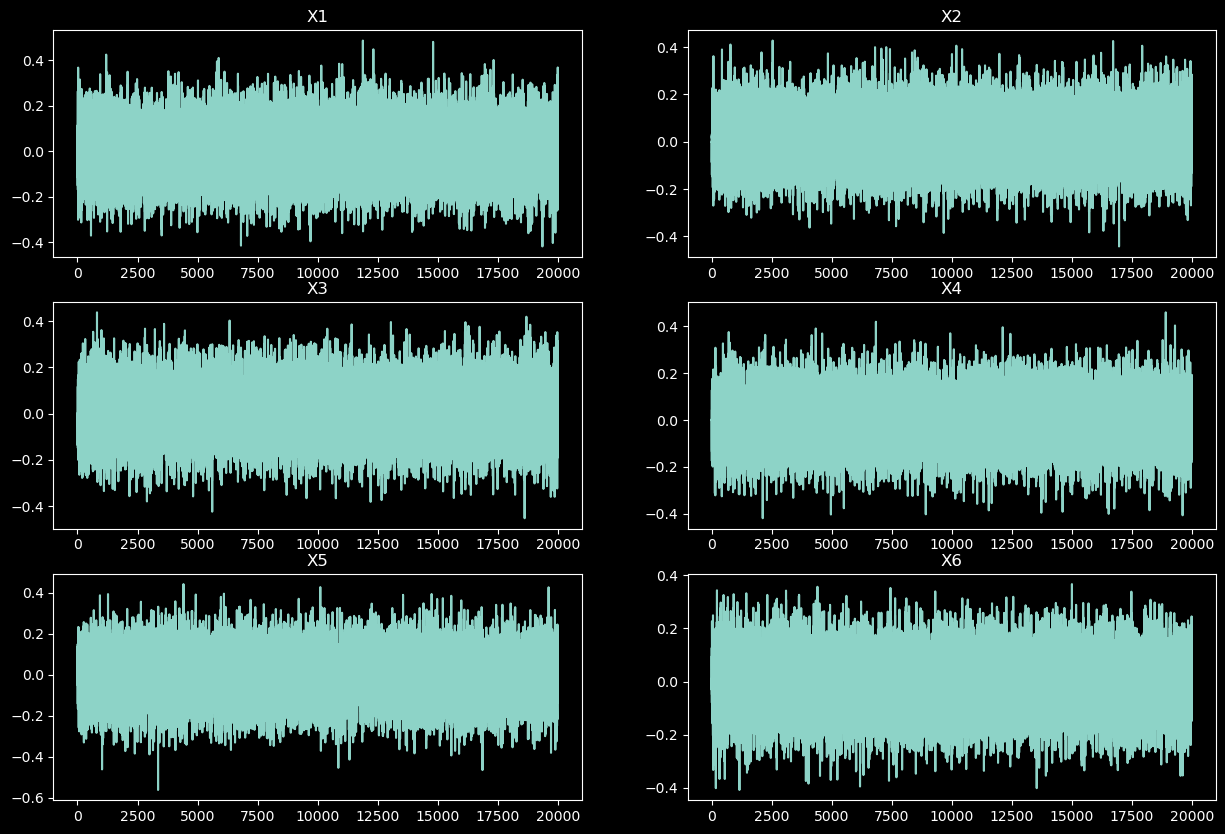

In [85]:

# plot X time series, for every feature, in a plot with 6 subplots, in a grid of 3x2
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
for f in range(features):
    axs[f//2, f%2].plot(X[f])
    axs[f//2, f%2].set_title('X' + str(f+1))
plt.show()


**Concept drift smooth transition** of size drift_width and at position drift_position, using a sigmoid function. The smooth concept drift is obtained by drawing random numbers from a uniform distribution. When the numbers picked happen to be below the sigmoid function, they will be part of the set of samples of the new distribution, thus representing the concept drift.

Assuming $T_d$ is the time at which the drifting probability is equal to $0.5$, and $w$ the "length" of the drifting period, the sigmoid function is computed as:

$$
\sigma(t) = \frac{1}{1 + e^{-4 (t - T_d) / w}}
$$


In [86]:
drifting_probabilities = np.random.uniform(0, 1, size=time_series_length)
drift_width = time_series_length / 50.0 # drift width is 2.5% of the time series length
drift_position = time_series_length / 2.0 # drift starts at the middle of the time series

# create sigmoid function used as probability of drift in time
sigmoid = [(1 / (1 + np.exp(- 4 * (t - drift_position) / drift_width))) for t in range(time_series_length)]

print("drifting position = ", drift_position, " with width = ", drift_width)

drifting position =  10000.0  with width =  400.0


Computation of 2 different labels and introduction of concept drift in the dataset. Here we have two slightly different labeling functions applied to the dataset. The function 1 is applied before the concept drift, while the function 2 is applied after.

$$
\begin{equation}

\begin{aligned}
&\text{if } (\text{drifting probabilities}[t] > \sigma(t)): \\
&\qquad \text{value} = \frac{1}{4} \sum_{i=0}^{4}  \left[\sin(2 \pi x_{0}(t-i)) + \sin(2 \pi x_{1}(t-i)) + \sin(2 \pi x_{3}(t-i)) \right] + \frac{1}{10} \sum_{i=1}^{3} e^{y(t-i)}
 \\
&\text{else:}\\
&\qquad \text{value} = \frac{1}{3} \sum_{i=0}^{2}\left[\sin(3 \pi x_{2}(t-i)) + \sin(3 \pi x_{4}(t-i)) + \sin(3 \pi x_{5}(t-i))\right] - \frac{1}{10} \sum_{i=1}^{3} e^{y(t-i)}


\\
&y(t) = \begin{cases} 1 &\text{if } value > 0 \\0 &\text{if } value < 0 \end{cases}
\end{aligned}
\end{equation}

$$

These labeling functions are structured so that they are non linear and based on different features for the computation. In fact, the first function uses the features $x_3, x_5, x_6$, while the second one uses $x_1, x_2, x_4$

In [87]:
# create binary labels named Y of length time_series_length
Y = np.zeros(time_series_length, dtype=np.int32)

# for every time t, apply label 1 or 2 to the time series according to the sigmoid function (drift or not)
for t in range(max(p, q), time_series_length):

	if (drifting_probabilities[t] > sigmoid[t]):
		# apply label 1
		value = np.sum([(np.sin(2 * np.pi * X[0][t - i]) + np.sin(2 * np.pi * X[1][t - i]) + np.sin(2 * np.pi * X[3][t - i])) for i in range(0, 5)])
		value = value / 4.0 + np.sum([np.exp(Y[t - i]) for i in range(1, 3)]) / 10.0

		# if value is negative, set it to 0, else to 1
		Y[t] = 1 if value > 0 else 0
		
	else:
		# apply label 2
		value = np.sum([(np.sin(3 * np.pi * X[2][t - i]) + np.sin(3 * np.pi * X[4][t - i]) + np.sin(3 * np.pi * X[5][t - i])) for i in range(0, 3)])
		value = value / 3.0 - np.sum([np.exp(Y[t - i]) for i in range(1, 3)]) / 10.0

		# if value is negative, set it to 0, else to 1
		Y[t] = 1 if value > 0 else 0


print("X shape = ", X.shape)
print("Y shape = ", Y.shape)



X shape =  (6, 20000)
Y shape =  (20000,)


plot binary labeling function (0s and 1s) and the sigmoid function for drift computation

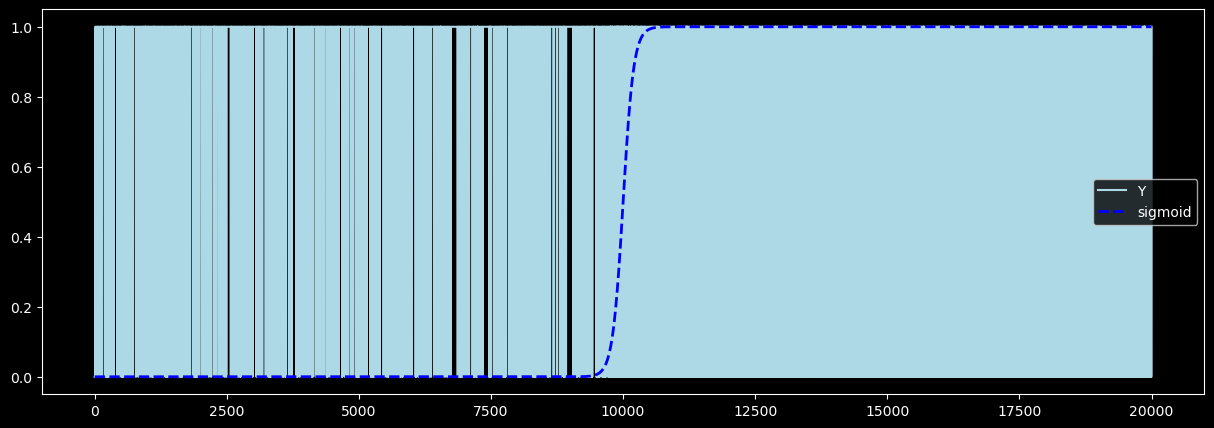

In [88]:

#plot Y time series and sigmoid in the same plot with different colors
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(Y, color='lightblue', label='Y')
ax.plot(sigmoid, color='blue', linestyle='--', linewidth=2)
# add legend to the plot
ax.legend(['Y', 'sigmoid'])
plt.show()


create numpy array with X as feature vectors and Y as binary labels

In [89]:
# create dataset using X as feature vectors and Y as binary labels
dataset = np.concatenate((X, [Y]), axis=0)
print("dataset shape = ", dataset.shape)


dataset shape =  (7, 20000)


Save computed time series into a csv file

In [90]:
# save dataset time series in a csv file, where each column is a time series and the last column is the label
np.savetxt("dataset_drift_labels.csv", dataset.T, delimiter=",")

## Second dataset with concept drift in the Non-Linear ARMA process polynomials parameters

In [91]:
# initialization of X and eps (gaussian noise)
X = np.zeros((features, time_series_length))
eps = np.random.normal(0, 0.1, (features, time_series_length))


Concept drift is created by changing the polynomials parameters. The new generated process is different in terms of cross correlation between variables. In fact now the features have different cross correlation between them, while having the same number of parameters as above for the computation of the non linear combination of coefficients and processes.

The generated polynomial parameters are very similar to the ones described in the equations above

In [92]:
def compute_polynomials_2(X, t):
	polynomial = np.zeros((features, parameters), dtype=np.float32)
	
	# polynomial combination of order 2 of X0 and eps0, and X[0:4]
	vector = np.array(np.concatenate([
						[X[0][t-i] for i in range(1, p+1)], [eps[0][t-i] for i in range(1, q+1)], 
						[X[0][t-i] **2 for i in range(1, p+1)],	[eps[0][t-i] **2 for i in range(1, q+1)],
						[X[0][t-i] * eps[0][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[4][t-i] for i in range(1, p+1)], [X[4][t-i] **2 for i in range(1, p+1)],
						[X[4][t-i] * X[0][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[5][t-i] for i in range(1, p+1)], [X[5][t-i] **2 for i in range(1, p+1)],
						[X[5][t-i] * X[0][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# create array with 5 rows, and vector as the content of the first row
	polynomial[0] = np.array([vector])

	# polynomial combination of order 2 of X1 and eps1, and X[0:4]
	vector = np.array(np.concatenate([
						[X[1][t-i] for i in range(1, p+1)], [eps[1][t-i] for i in range(1, q+1)], 
						[X[1][t-i] **2 for i in range(1, p+1)], [eps[1][t-i] **2 for i in range(1, q+1)],
						[X[1][t-i] * eps[1][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[3][t-i] for i in range(1, p+1)], [X[3][t-i] **2 for i in range(1, p+1)],
						[X[3][t-i] * X[1][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[2][t-i] for i in range(1, p+1)], [X[2][t-i] **2 for i in range(1, p+1)],
						[X[2][t-i] * X[1][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# add vector to polynomial
	#polynomial = np.append(polynomial, [vector], axis=0)
	polynomial[1] = np.array([vector])


	# polynomial combination of order 2 of X2 and eps2, and X[0:4]
	vector = np.array(np.concatenate([
						[X[2][t-i] for i in range(1, p+1)], [eps[2][t-i] for i in range(1, q+1)], 
						[X[2][t-i] **2 for i in range(1, p+1)],
						[eps[2][t-i] **2 for i in range(1, q+1)],
						[X[2][t-i] * eps[2][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[3][t-i] for i in range(1, p+1)], [X[3][t-i] **2 for i in range(1, p+1)],
						[X[3][t-i] * X[2][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[1][t-i] for i in range(1, p+1)], [X[1][t-i] **2 for i in range(1, p+1)],
						[X[1][t-i] * X[2][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# add vector to polynomial
	#polynomial = np.append(polynomial, [vector], axis=0)
	polynomial[2] = np.array([vector])


	# polynomial combination of order 2 of X3 and eps3, and X4 and X5
	vector = np.array(np.concatenate([
						[X[3][t-i] for i in range(1, p+1)], [eps[3][t-i] for i in range(1, q+1)], 
						[X[3][t-i] **2 for i in range(1, p+1)],
						[eps[3][t-i] **2 for i in range(1, q+1)],
						[X[3][t-i] * eps[3][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[1][t-i] for i in range(1, p+1)], [X[1][t-i] **2 for i in range(1, p+1)],
						[X[1][t-i] * X[3][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[2][t-i] for i in range(1, p+1)], [X[2][t-i] **2 for i in range(1, p+1)],
						[X[2][t-i] * X[3][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# add vector to polynomial
	#polynomial = np.append(polynomial, [vector], axis=0)
	polynomial[3] = np.array([vector])


	# polynomial combination of order 2 of X4 and eps4, and X3, X5
	vector = np.array(np.concatenate([
						[X[4][t-i] for i in range(1, p+1)], [eps[4][t-i] for i in range(1, q+1)], 
						[X[4][t-i] **2 for i in range(1, p+1)],
						[eps[4][t-i] **2 for i in range(1, q+1)],
						[X[4][t-i] * eps[4][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[5][t-i] for i in range(1, p+1)], [X[5][t-i] **2 for i in range(1, p+1)],
						[X[5][t-i] * X[4][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[0][t-i] for i in range(1, p+1)], [X[0][t-i] **2 for i in range(1, p+1)],
						[X[0][t-i] * X[4][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# add vector to polynomial
	#polynomial = np.append(polynomial, [vector], axis=0)
	polynomial[4] = np.array([vector])

	# polynomial combination of order 2 of X4 and eps4, and X3, X5
	vector = np.array(np.concatenate([
						[X[5][t-i] for i in range(1, p+1)], [eps[5][t-i] for i in range(1, q+1)], 
						[X[5][t-i] **2 for i in range(1, p+1)],
						[eps[5][t-i] **2 for i in range(1, q+1)],
						[X[5][t-i] * eps[5][t-j] for i in range(1, p+1) for j in range(1, q+1)],
						[X[0][t-i] for i in range(1, p+1)], [X[0][t-i] **2 for i in range(1, p+1)],
						[X[0][t-i] * X[5][t-j] for i in range(1, p+1) for j in range(1, p+1)],
						[X[4][t-i] for i in range(1, p+1)], [X[4][t-i] **2 for i in range(1, p+1)],
						[X[4][t-i] * X[5][t-j] for i in range(1, p+1) for j in range(1, p+1)]
						]), dtype=np.float32)

	# add vector to polynomial
	#polynomial = np.append(polynomial, [vector], axis=0)
	polynomial[5] = np.array([vector])

	return polynomial
	

Computation of the dot product between the polynomial parameters and the coefficients. Here the concept drift is in the features processes, meaning that the polynomials change after the concept drift. Basically, the variables are cross-correlated in a different way, so that the feature processes are generated in a different manner, while maintaining the same p, q values as above.

Another change is in the choice of the random coefficient values, with another function:
$$
\begin{aligned}
\text{coefficients} = \frac{\beta}{10} \cdot sign(u), \quad & \text{ where } \beta \sim Beta(2, 5) \\ 
& \text{ and } sign \in \{-1, 1\} \text{ is randomly chosen} 
\end{aligned}
$$

Note that $sign$ represents a random sign (positive or negative), which means that the elements of  $\text{coefficients}$ can be either positive or negative with equal probability.


In [93]:
X = np.zeros((features, time_series_length))
eps = np.random.normal(0, 0.1, (features, time_series_length))

# array of coefficients taken from normal distribution with mean 0 and variance 0.05 of shape = vector.shape

coefficients = np.random.beta(a = 2, b = 5, size = (features, parameters)) * np.random.choice([-1, 1], size = (features, parameters)) / 10
print("coefficient shape = ", coefficients.shape)


# for each time stamp t in the time series
for t in range(max(p, q), time_series_length):

    # compute polynomial combination of order 2 for all features and time steps
    polynomials_1 = compute_polynomials(X, t)
    polynomials_2 = compute_polynomials_2(X, t)

    for f in range(features):
        # assign coefficients based on the probability of concept drift at time t
        if (drifting_probabilities[t] > sigmoid[t]):
            # compute dot product between coefficients and polynomial, for every f
            X[f][t] = np.dot(coefficients[f], polynomials_1[f]) + eps[f][t]
        else:
            # compute dot product between coefficients and polynomial, for every f
            X[f][t] = np.dot(coefficients[f], polynomials_2[f]) + eps[f][t]



coefficient shape =  (6, 136)


plot the features over time

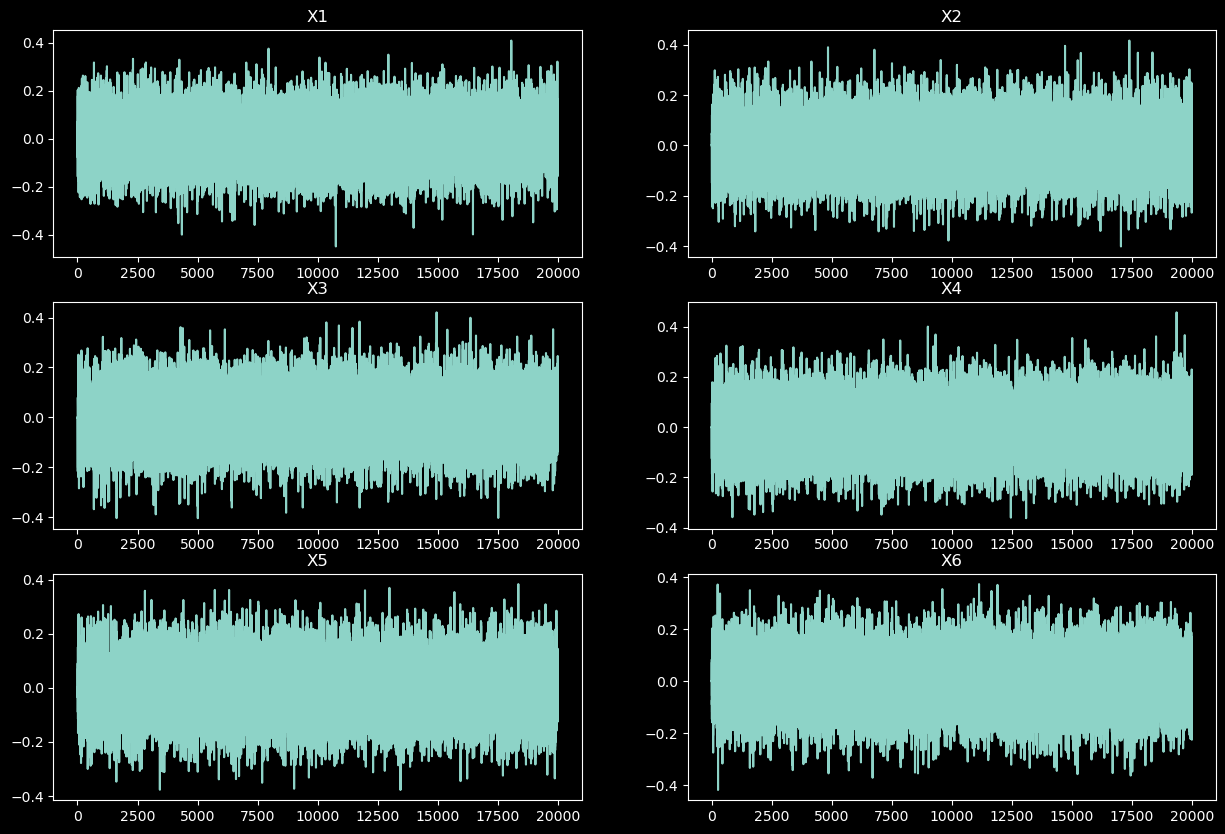

In [94]:

# plot X time series, for every feature, in a plot with 6 subplots, in a grid of 3x2
fig, axs = plt.subplots(3, 2, figsize=(15, 10))
for f in range(features):
    axs[f//2, f%2].plot(X[f])
    axs[f//2, f%2].set_title('X' + str(f+1))
plt.show()


Binary labeling function is unique and constant over time. It is very similar to the functions above

In [95]:
# create binary labels named Y of length time_series_length
Y = np.zeros(time_series_length, dtype=np.int32)

# for every time t, apply label 1 or 2 to the time series according to the sigmoid function (drift or not)
for t in range(max(p, q), time_series_length):
	# apply binary label function
	value = np.sum([(np.sin(2 * np.pi * X[0][t - i]) + np.sin(2 * np.pi * X[1][t - i]) + np.sin(2 * np.pi * X[3][t - i])) for i in range(0, 5)])
	value = value / 4.0 + np.sum([np.exp(Y[t - i]) for i in range(1, 3)]) / 15.0

	# if value is negative, set it to 0, else to 1
	Y[t] = 1 if value > 0 else 0

print("X shape = ", X.shape)
print("Y shape = ", Y.shape)



X shape =  (6, 20000)
Y shape =  (20000,)


Plot the binary labeling function and the sigmoid probability for concept drifting

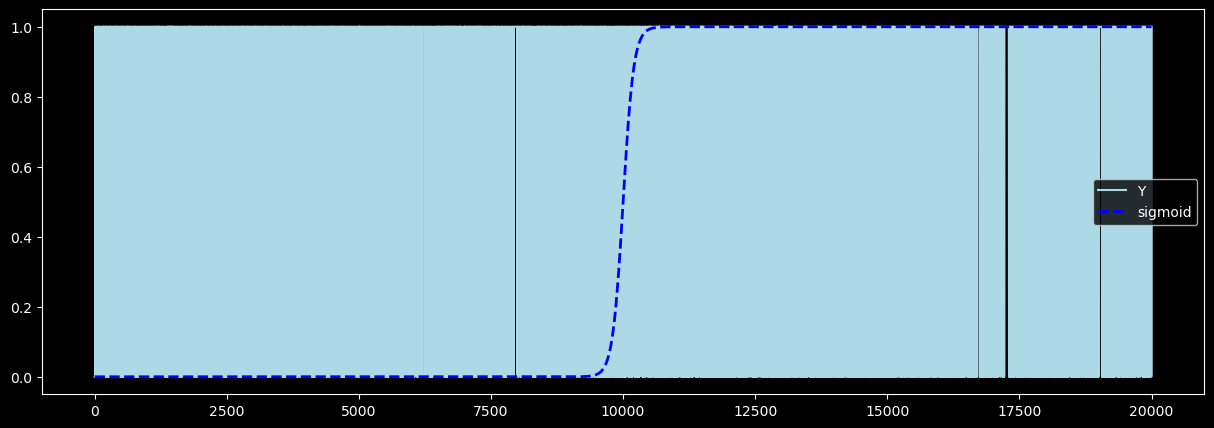

In [96]:

#plot Y time series and sigmoid in the same plot with different colors
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(Y, color='lightblue', label='Y')
ax.plot(sigmoid, color='blue', linestyle='--', linewidth=2)
# add legend to the plot
ax.legend(['Y', 'sigmoid'])
plt.show()


create dataset with features X and binary labels Y

In [97]:
# create dataset using X as feature vectors and Y as binary labels
dataset = np.concatenate((X, [Y]), axis=0)
print("dataset shape = ", dataset.shape)

dataset shape =  (7, 20000)


In [98]:
# save dataset time series in a csv file, where each column is a time series and the last column is the label
np.savetxt("dataset_drift_features.csv", dataset.T, delimiter=",")

## Third dataset with no concept drift in the time series

This dataset is used mainly for statistical tests and for baseline comparison with respect to the other datasets that instead employ a concept drift.

In [99]:
# initialization of X and eps (gaussian noise)
X = np.zeros((features, time_series_length))
eps = np.random.normal(0, 0.1, (features, time_series_length))

print("creation of a dataset without any concept drift ...")

creation of a dataset without any concept drift ...


No concept drift in the features...

In [100]:

# array of coefficients taken from normal distribution with mean 0 and variance 0.05 of shape = vector.shape
# 2 arrays of coefficients used before and after concept drift
coefficients = np.random.normal(0, 0.1, (features, parameters))
print("coefficient shape = ", coefficients.shape)

# for each time stamp t in the time series
for t in range(max(p, q), time_series_length):

    # compute polynomial combination of order 2 for all features and time steps
    polynomial = compute_polynomials(X, t)

    for f in range(features):
        # compute dot product between coefficients and polynomial, for every f
        X[f][t] = np.dot(coefficients[f], polynomial[f]) + eps[f][t]



coefficient shape =  (6, 136)


... nor in the labeling function

In [101]:
# create binary labels named Y of length time_series_length
Y = np.zeros(time_series_length, dtype=np.int32)

# for every time t, apply label 1 or 2 to the time series according to the sigmoid function (drift or not)
for t in range(max(p, q), time_series_length):
	# apply binary label function
	value = np.sum([(np.sin(2 * np.pi * X[0][t - i]) + np.sin(2 * np.pi * X[1][t - i]) + np.sin(2 * np.pi * X[3][t - i])) for i in range(0, 5)])
	value = value / 4.0 + np.sum([np.exp(Y[t - i]) for i in range(1, 3)]) / 10.0

	# if value is negative, set it to 0, else to 1
	Y[t] = 1 if value > 0 else 0

print("X shape = ", X.shape)
print("Y shape = ", Y.shape)



X shape =  (6, 20000)
Y shape =  (20000,)


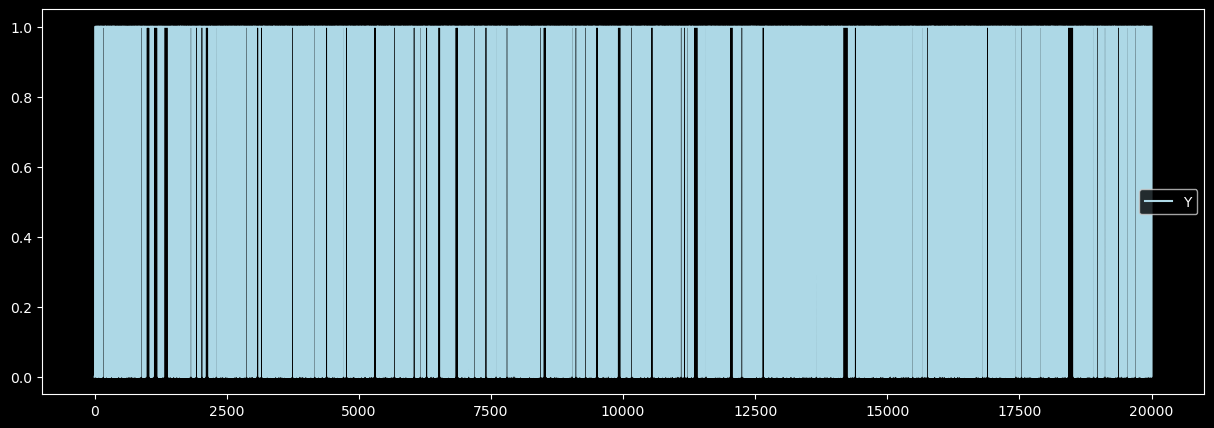

In [102]:

#plot Y time series and sigmoid in the same plot with different colors
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(Y, color='lightblue', label='Y')
#ax.plot(sigmoid, color='blue', linestyle='--', linewidth=2)
# add legend to the plot
ax.legend(['Y', 'sigmoid'])
plt.show()


In [103]:
# create dataset using X as feature vectors and Y as binary labels
dataset = np.concatenate((X, [Y]), axis=0)
print("dataset shape = ", dataset.shape)

dataset shape =  (7, 20000)


Save the dataset in a csv file

In [104]:
# save dataset time series in a csv file, where each column is a time series and the last column is the label
np.savetxt("dataset_no_drift.csv", dataset.T, delimiter=",")